# Research Notebook: Running test cases on CFMiso to probe its abilities and limits


Here we will curate some initial surface conditions, and test the limits of the firn depth for this model.
The primary tests here will be around the Tskin. 
1. ability to simulate step changes, 
2. ability to simulate seasonal cycles, 
3. limits of firn depth in these simulations.
4. test limits and format of time resolution

These simulations will be run with a bdot = 0.

Input/output will be saved the ./CommunityFirnModel/data folder 

Start this notebook from the ./CommunityFirnModel repo directory on your computer 

In [23]:
import sys 

## run from notebooks folder
homePath= './CFM_main/'
inputDataPath = '../data/input/'
outputDataPath = '../data/output/'

sys.path.append(homePath)
sys.path.append('/home/michaeltown/work/python/figures/')

### Import necessary libraries

In [61]:
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle 
import seaborn as sns 
import glob
from datetime import datetime, timedelta, date
import time
import json
import shutil
import xarray as xr
import copy
import pprint
import figureMagic as fm

SPY = 365.25*24*3600

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

In [62]:
# get the starting point of this notebook, so it can be used later if this 
# notebook needs to be restarted in the middle
cwdIpynb = os.path.abspath("")

### Set plot parameters (seaborn, matplotlib)

In [63]:
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20

### Curate/create, save, and then upload the input data for these tests. 

In [64]:

# temperature/density time series for sinusoidal tests in pandas format at minute resolution, hourly resolution, daily resolution, monthly resolution.

# add different levels of noise at the time scales (e.g. 0.1 K, 1 k, 2 k, 4 k)

cycles = 10 # how many sine cycles
resolution = 365*24*60*10 # how many datapoints to generate

length = np.pi * 2 * cycles

DTseas = 20 # size of seasonal cycle, K
Tannual = 243 # mean annual temperature, K

Tseasonal = DTseas*np.sin(np.arange(0, length, length / resolution))+Tannual
numDays = np.arange(1,len(Tseasonal)+1)

# make a snow density annual time series based on the rough guidance of Brils et al. 2022

meanSrho = 300 # kg/m3, July
dSrho = 10 # kg/m3, Jan
SrhoSeasonal = dSrho*np.sin(np.arange(0, length, length / resolution))+meanSrho



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2000-01-01 00:00:00 to 2009-12-28 23:00:00
Freq: h
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tseas0noise    87600 non-null  float64
 1   Tseas0.1noise  87600 non-null  float64
 2   Tseas1noise    87600 non-null  float64
 3   Tseas2noise    87600 non-null  float64
 4   Tseas4noise    87600 non-null  float64
 5   Tseas10noise   87600 non-null  float64
dtypes: float64(6)
memory usage: 4.7 MB


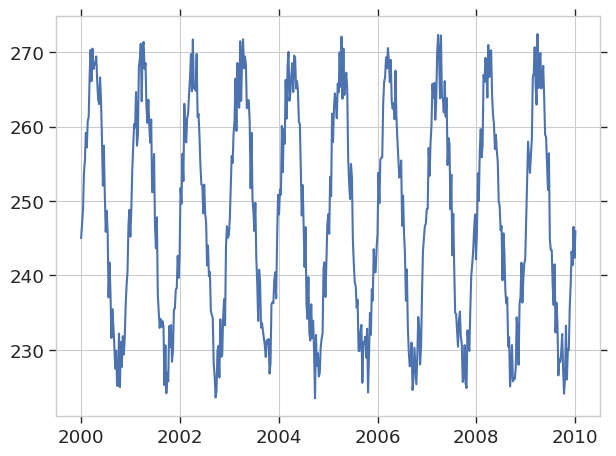

In [65]:
# create the input time series

inputDF_min = pd.DataFrame(index = pd.DatetimeIndex(pd.period_range(start = '2000-01-01',periods=resolution,freq='min').to_timestamp()), columns = ['Tseas0noise','Srho0noise'])
inputDF_min.Tseas0noise= Tseasonal
inputDF_min.Srho0noise = SrhoSeasonal

inputDF_hour = inputDF_min.resample('h').mean()
inputDF_day = inputDF_min.resample('D').mean()
inputDF_week = inputDF_min.resample('W').mean()
inputDF_month = inputDF_min.resample('MS').mean()

# create random noise for the model tests
lenMin = len(inputDF_min.index)
lenHour = len(inputDF_hour.index)
lenDaily = len(inputDF_day.index)
lenWeek = len(inputDF_week.index)
lenMonth = len(inputDF_month.index)

listLevels_T = [0.1,1,2,4,10] # noise levels in K


# add noise to the temperature data
for l in listLevels_T:
    inputDF_min['Tseas'+str(l)+'noise'] = inputDF_min.Tseas0noise + np.random.rand(lenMin)*l
    inputDF_hour['Tseas'+str(l)+'noise'] = inputDF_hour.Tseas0noise + np.random.rand(lenHour)*l
    inputDF_day['Tseas'+str(l)+'noise'] = inputDF_day.Tseas0noise + np.random.rand(lenDaily)*l
    inputDF_week['Tseas'+str(l)+'noise'] = inputDF_week.Tseas0noise + np.random.rand(lenWeek)*l
    inputDF_month['Tseas'+str(l)+'noise'] = inputDF_month.Tseas0noise + np.random.rand(lenMonth)*l

# add noise to the surface density data
for l in listLevels_T:
    inputDF_min['Tseas'+str(l)+'noise'] = inputDF_min.Tseas0noise + np.random.rand(lenMin)*l
    inputDF_hour['Tseas'+str(l)+'noise'] = inputDF_hour.Tseas0noise + np.random.rand(lenHour)*l
    inputDF_day['Tseas'+str(l)+'noise'] = inputDF_day.Tseas0noise + np.random.rand(lenDaily)*l
    inputDF_week['Tseas'+str(l)+'noise'] = inputDF_week.Tseas0noise + np.random.rand(lenWeek)*l
    inputDF_month['Tseas'+str(l)+'noise'] = inputDF_month.Tseas0noise + np.random.rand(lenMonth)*l



# make initial temperature profile (no spin up) for step-change tests, make step change temperature time series of 
# different magnitudes (0.1 K, 1 K, 2 K, 10 K). Use the same array of time resolution.

inputDF_min.head()

plt.figure
plt.plot(inputDF_week.index,inputDF_week.Tseas10noise)

inputDF_hour.info()


In [66]:
# fill in the rest of the DFs for evaporation, melt, total precip, snow precip, everything is zero at this point for these parameters

massParamsList = ['EVAP','SMELT','PRECTOT','PRECSNO']

for m in massParamsList:
    if (m == 'EVAP') | (m == 'SMELT'):
        inputDF_min[m]=0;
        inputDF_hour[m]=0;
        inputDF_day[m]=0;
        inputDF_week[m]=0;
        inputDF_month[m]=0;
    else:
        inputDF_min[m]=1/365/24/60;
        inputDF_hour[m]=1/365/24;
        inputDF_day[m]=1/365;
        inputDF_week[m]=1/52;
        inputDF_month[m]=1/12;
        
inputDF_week.to_csv(inputDataPath+'modelTest_1wk_res.csv')
inputDF_week.to_pickle(inputDataPath+'modelTest_1wk_res.pkl')
inputDF_month.to_csv(inputDataPath+'modelTest_1mon_res.csv')
inputDF_week.to_pickle(inputDataPath+'modelTest_1mon_res.pkl')

In [67]:
# check sum on the massParams

print(inputDF_week.PRECSNO.sum())
print(inputDF_month.PRECSNO.sum())


10.057692307692305
9.999999999999998


In [72]:
# create dictionary of dataframes for this series of tests

listRes = ['1W','1M']   # what is the abbreviation for, probably the resample abbreviations
noiseDict = dict(zip(['0','0.1','1','2','4','10'],['Tseas0noise','Tseas0.1noise','Tseas1noise','Tseas2noise','Tseas4noise','Tseas10noise']))
dfExpDict = dict(zip(listRes,[inputDF_week, inputDF_month]))

# specify snow density
# srho = 'KM15'
# srho = 'Brils22'


### Set CFM configuration

In [73]:
os.chdir(cwdIpynb)

### NOTE: 22 March 2024 -- get this json file to be more reactive to the input parameters and file names generated below

### This function contains all of the CFM configuration options.
### The values here are more or less the defaults.
### You can change them here if you want to change default settings,
### but if you want to change on a run-by-run basis I recommend doing so in the cell below.

# doublegrid to True - turning on double grid routine (for faster running of things, allowing thicker firn column without much higher run times).

def makejson(ipd,opd):
    false = False
    true = True
    c = {
    "InputFileFolder": ipd,
    "InputFileNameTemp": "tskin.csv",
    "InputFileNamebdot": "smb.csv",
    "InputFileNameIso": "isotope.csv",
    "InputFileNamerho": "rhos.csv",
    "InputFileNamemelt": "melt.csv",
    "resultsFolder": opd,
    "initfirnFile": "firndata.csv",
    "initprofile": false,
    "input_type": "dataframe",
    "input_type_options": ["csv","dataframe"],
    "DFresample": "1D",
    "DFfile": "inputData.pkl",
    "physRho": "GSFC2020",
    "physRho_options":["HLdynamic","HLSigfus","Li2004","Li2011","Helsen2008","Arthern2010S","Arthern2010T","Li2015","Goujon2003","Barnola1991","Morris2014","KuipersMunneke2015","Crocus","Ligtenberg2011"],
    "MELT": false,
    "ReehCorrectedT": false,
    "FirnAir": false,
    "AirConfigName": "AirConfig.json",
    "TWriteInt": 1,
    "TWriteStart": 1980.0,
    "int_type": "nearest",
    "int_type_options": ["nearest","linear"],
    "SeasonalTcycle": false,
    "SeasonalThemi": "north",
    "coreless": true,
    "TAmp":10.0,
    "physGrain": false,
    "calcGrainSize": false,
    "GrGrowPhysics": "Arthern",
    "GrGrowPhysics_options": ["Arthern", "Katsushima"],
    "heatDiff": true,
    "conductivity": "Calonne2019",
    "conductivity_options": ["Schwander","Yen_fixed","Yen_var","Anderson","Yen_b","Sturm","VanDusen","Schwerdtfeger","Riche","Jiawen","mix","Calonne2011","Calonne2019"],
    "variable_srho": true,
    "srho_type": srho,
    "srho_type_options": ["userinput","param","noise"],
    "rhos0": 350.0,
    "r2s0": 1.0e-8,
    "AutoSpinUpTime": false,
    "yearSpin": 20,
    "H": 3000,
    "HbaseSpin": 2880.0,
    "stpsPerYear": 12.0,
    "D_surf": 1.0,
    "bdot_type": "instant",
    "bdot_type_options": ["instant","mean","stress"],
    "grid_outputs": True,
    "grid_output_res": 0.25,
    "isoDiff": true,
    "iso": ["d18O","dD"],
    "isoOptions":["d18O","dD","NoDiffusion"],
    "spacewriteint": 1,
    "strain": false,
    "du_dx": 1e-5,
    "outputs": ["density", "depth", "temperature", "age", "DIP","isotopes"],
    "outputs_options": ["density", "depth", "temperature", "age", "Dcon", "bdot_mean", "climate", "compaction", "grainsize", "temp_Hx", "isotopes", "BCO", "DIPc", "DIP", "LWC","gasses", "PLWC_mem", "viscosity", "runoff",
    "refrozen"],
    "resultsFileName": 'tempResults.hdf5',
    "spinFileName": 'tempSpin.hdf5',
    "doublegrid": true,
    "nodestocombine": 30,
    "multnodestocombine": 12,
    "Dnodestocombine": 30,
    "Dmultnodestocombine": 12,
    "grid1bottom": 5.0,
    "grid2bottom": 10.0,
    "spinup_climate_type": "mean",
    "spinup_climate_type_options": ["mean", "initial"],
    "manual_climate": false,
    "deepT": 255.88,
    "bdot_long": 0.49073,
    "manual_iceout": false,
    "iceout": 0.23,
    "QMorris": 110.0e3,
    "timesetup": "exact",
    "timesetup_options": ["exact","interp","retmip"],
    "liquid": "bucket",
    "liquid_options": ["percolation_bucket","bucketVV","resingledomain","prefsnowpack"],
    "merging": false,
    "merge_min": 1e-4,
    "LWCcorrect": false,
    "manualT": false,
    "no_densification": false,
    "rad_pen": false,
    "site_pressure": 1013.25,
    "output_bits": "float32",
    "spinUpdate": true,
    "spinUpdateDate": 1980.0,
    "DIPhorizon": 100.0,
    "NewSpin": true,
    "ColeouLesaffre": false,
    "IrrVal": 0.02,
    "RhoImp": 830.0,
    "DownToIce": false,
    "ThickImp": 0.1,
    "Ponding": false,
    "DirectRunoff": 0.0,
    "RunoffZuoOerlemans": false,
    "Slope": 0.1,
    "SUBLIM": True
    }

    return c

### Info on how CFM runs

The CFM itself (i.e, firn_density_nospin.py) takes inputs as vectors of temperature, accumulation, etc., and decimal time. 
The following line calls a script that takes the df_daily and creates a python dictionary (called Cd, for climate dictionary)
containing the vectors that the CFM needs to run. (converts the data from df_daily into these vectors)
the function also returns some other variables that will be used to configure the CFM run. (but are not important for what you are doing, generally speaking)

so, if you want to create your own forcing data you can either create a dataframe with a datetime index, which gets turned into the dictionary in the below function call,
or you could just create a dictionary with the needed keys (['time', 'TSKIN', 'BDOT', 'd18O', 'dD']), where 'time' is decimal date
we can't use pandas exclusively with datetime indicies because the datetime64 format has limitations


#### Configure the CFM run.
the variable 'c' is a dictionary with key-value pairs
if you want to alter anything in the config file I recommend doing so here.
note that not all CFM features will work with isotopes turned on - let me know if I need to change anything for you in that regard.



In [74]:
inputDataPath

'../data/input/'

In [75]:
# try to run with spin files, the spin files need to have the same time resolution as the no spin files. 
# save the spin files and move to another location. Then move and load the spin files for the next time you need them

# next step - tyr to create a series of init profiles, then run with no spin. 



for res in listRes:

    timeres = res # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc

    for n in noiseDict:

        if 'W' in res:
            resDir = 'weekly/'
        elif 'M' in res:
            resDir = 'monthly/'
        configName = outputDataPath + 'modelTests/' + resDir + f'modelTest_{res}_res_{n}_noise_{srho}.json'

        print('***********************************************')
        print('running ' + res + ' resolution with ' + n + ' noise.')
        print('using config name: ' + configName)
        print('***********************************************')
        

        
        inputDF = dfExpDict[res].copy()
        inputDF = inputDF.loc[:,[noiseDict[n]]+massParamsList]
        inputDF = inputDF.rename(columns = {noiseDict[n]: 'TSKIN'})
        inputDF.to_pickle(inputDataPath+'inputDF.pkl')
        
        if ((os.path.exists(configName) == False) & (os.path.exists(configName[:-4]+'hdf5') == False)):
            Cd, StpsPerYr, depth_S1, depth_S2, grid_bottom = makeSpinFiles(inputDF, timeres=timeres, Tinterp='mean', spin_date_st = 1990, spin_date_end = 2000, desired_depth=20)

        # set bottom density to be 700-800 kg/m3, rho_bottom = ?,then maybe don't set desired depth
        # or set desired_depth to a small depth. 

        # lower boundary condition is currently zero gradient, so maybe 
        # will not get longer run times for deeper snow, necessarily
        # set up sub-grid routine in json 

            # OK, this is wrong, but we will operate with it. This will have to be a different part of 'makeSpinFiles'
            Cd['d18O'] = 0.62* Cd['TSKIN'] - 15.25 #Johnsen 1989 eq. 2
            Cd['dD'] = 8.0 * Cd['d18O'] + 10 #Johnsen 1989 eq. 1
        
            runid=-9999
        
            #######
            ### Prepare config .json (which is a dictionary called c within this python script) ###
            ### edit as you wish here (the makejson function above just has defaults, you can change there as well)
            c = makejson(inputDataPath,outputDataPath)
            c['physRho'] = 'KuipersMunneke2015' # try with 'GSFC2020' and 'KuipersMunneke2015'
            c['runID'] = runid
            c['DFresample'] = timeres # resolution of the model run, e.g. '1d' is 1 day.
            c["doublegrid"] = False
            c['nodestocombine'] = 6 
            c['multnodestocombine'] = 12
            c['melt'] = False #you can set to false to make things run a lot faster if don't care about results
            c["stpsPerYear"] = StpsPerYr
            c["stpsPerYearSpin"] = StpsPerYr
            c["grid1bottom"] = 5
            c["grid2bottom"] = 10
            # c["grid1bottom"] = depth_S1
            # c["grid2bottom"] = depth_S2
            c["HbaseSpin"] = 3000 - grid_bottom
            c["DIPhorizon"] = np.floor(0.8*grid_bottom) # firn air content, depth integrated porosity 
            c["rhos0"] = 325.0  # e.g here you could change the surface density
            ### Specify where results should go ###
            ### alter this to reflect model-run specifics if e.g. you are doing several similar runs just varying one model setting

            reDir = '../data/output/modelTests/'+resDir
            c['resultsFolder'] = reDir
            c['resultsFileName'] = 'modelTestResults_' + res + '_res_' + n + f'_noise_srho{srho}.hdf5'
            c['spinFileName'] = 'modelTestSpin_' + res + '_res_' + n + f'_noise_srho{srho}.hdf5'
            ##########
            with open(configName,'w') as fp:
                fp.write(json.dumps(c,sort_keys=True, indent=4, separators=(',', ': ')))

        else:
            print('Both Json and spin files exist. Skipping spin step.')
            # read in existing json file
            
            with open(configName, 'r') as fp: 
                c = json.load(fp)

                    
                    
       
            


        ### start the CFM run
        if os.path.exists(c['resultsFolder']+c['resultsFileName']) == False:
            tnow = time.time()
            
            firn = FirnDensityNoSpin(configName,climateTS = Cd, NewSpin = True)
            firn.time_evolve()
            telap = (time.time()-tnow)/60
            print('main done, {} minutes'.format(telap))
        else:
            print('Results hdf5 file ' + c['resultsFileName'] +' exists. Skipping model run step.')
            print('***********************************************')

        



***********************************************
running 1W resolution with 0 noise.
using config name: ../data/output/modelTests/weekly/modelTest_1W_res_0_noise_Brils22.json
***********************************************
0.0010944061633650238
243.0001876833948
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16270.997268  243.344131       0      0   0.0  0.019231
-16270.978142  244.889472       0      0   0.0  0.019231
-16270.959016  247.267718       0      0   0.0  0.019231
-16270.939891  249.584072       0      0   0.0  0.019231
-16270.920765  251.804939       0      0   0.0  0.019231
stepsperyear: 4.844099704186479
Spin run started
physics are KuipersMunneke2015
Grid length is 88524
AHL: 0.0010944061633650238
THL: 243.00507251925595
It is not recommended to use instant accumulation with Ligtenberg 2011 physics


/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.61148733538596
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.614754098360663 2010.0054794520547
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 1535.0793944048883
main done, 27.531819550196328 minutes
***********************************************
running 1W resolution with 0.1 noise.
using config name: ../data/output/modelTests/weekly/modelTest_1W_res_0.1_noise_Brils22.json
***********************************************
0.0010944061633650238
243.04976255154764
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16270.997268  243.424002       0      0   0.0  0.019231
-16270.978142  244.945502       0      0   0.0  0.019231
-16270.959016  247.28816

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


It is not recommended to use instant accumulation with Ligtenberg 2011 physics
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.61148733538596
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.614754098360663 2010.0054794520547
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 1618.220793333292
main done, 28.136579100290934 minutes
***********************************************
running 1W resolution with 1 noise.
using config name: ../data/output/modelTests/weekly/modelTest_1W_res_1_noise_Brils22.json
***********************************************
0.0010944061633650238
243.51919754307238
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16270.997268  243.525621       0      0   0.0  0.019231
-16270.

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


It is not recommended to use instant accumulation with Ligtenberg 2011 physics
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.61148733538596
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.614754098360663 2010.0054794520547
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 1645.4168285639287
main done, 28.45964823961258 minutes
***********************************************
running 1W resolution with 2 noise.
using config name: ../data/output/modelTests/weekly/modelTest_1W_res_2_noise_Brils22.json
***********************************************
0.0010944061633650238
243.996486594277
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16270.997268  244.238445       0      0   0.0  0.019231
-16270.97

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.61148733538596
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.614754098360663 2010.0054794520547
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 1721.831339073658
main done, 27.757977843284607 minutes
***********************************************
running 1W resolution with 4 noise.
using config name: ../data/output/modelTests/weekly/modelTest_1W_res_4_noise_Brils22.json
***********************************************
0.0010944061633650238
245.0697298110839
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16270.997268  245.511189       0      0   0.0  0.019231
-16270.978142  245.018292       0      0   0.0  0.019231
-16270.959016  250.033846     

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


It is not recommended to use instant accumulation with Ligtenberg 2011 physics
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.61148733538596
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.614754098360663 2010.0054794520547
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 1548.7571902379989
main done, 26.44576811393102 minutes
***********************************************
running 1W resolution with 10 noise.
using config name: ../data/output/modelTests/weekly/modelTest_1W_res_10_noise_Brils22.json
***********************************************
0.0010944061633650238
247.92205808881852
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16270.997268  245.016902       0      0   0.0  0.019231
-1627

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


It is not recommended to use instant accumulation with Ligtenberg 2011 physics
Main run starting
physics are KuipersMunneke2015
updatedStartDate 20.61148733538596
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.614754098360663 2010.0054794520547
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 1502.7778306584357
main done, 26.884205702940623 minutes
***********************************************
running 1M resolution with 0 noise.
using config name: ../data/output/modelTests/monthly/modelTest_1M_res_0_noise_Brils22.json
***********************************************
0.0010906636140245313
243.07590598877488
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16336.918033  248.210848       0      0   0.0  0.083333
-1633

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 19.23477144865165
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.081967213114694 2009.9972602739726
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 64.81315240859985
main done, 1.1022287050882975 minutes
***********************************************
running 1M resolution with 0.1 noise.
using config name: ../data/output/modelTests/monthly/modelTest_1M_res_0.1_noise_Brils22.json
***********************************************
0.0010906636140245313
243.1245679233889
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16336.918033  248.212689       0      0   0.0  0.083333
-16336.838798  257.018840       0      0   0.0  0.083333
-16336.754098  262.110679

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 19.23477144865165
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.081967213114694 2009.9972602739726
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 60.52316061973572
main done, 1.0907931923866272 minutes
***********************************************
running 1M resolution with 1 noise.
using config name: ../data/output/modelTests/monthly/modelTest_1M_res_1_noise_Brils22.json
***********************************************
0.0010906636140245313
243.5322679171672
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16336.918033  248.377927       0      0   0.0  0.083333
-16336.838798  257.686104       0      0   0.0  0.083333
-16336.754098  262.766352    

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 19.23477144865165
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.081967213114694 2009.9972602739726
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 66.81229405403137
main done, 1.13882980744044 minutes
***********************************************
running 1M resolution with 2 noise.
using config name: ../data/output/modelTests/monthly/modelTest_1M_res_2_noise_Brils22.json
***********************************************
0.0010906636140245313
244.06649594880582
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16336.918033  248.984044       0      0   0.0  0.083333
-16336.838798  258.649830       0      0   0.0  0.083333
-16336.754098  263.812199     

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 19.23477144865165
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.081967213114694 2009.9972602739726
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 64.45179479599
main done, 1.1044630686442056 minutes
***********************************************
running 1M resolution with 4 noise.
using config name: ../data/output/modelTests/monthly/modelTest_1M_res_4_noise_Brils22.json
***********************************************
0.0010906636140245313
245.05091937581037
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16336.918033  250.676014       0      0   0.0  0.083333
-16336.838798  260.687923       0      0   0.0  0.083333
-16336.754098  262.431823      

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 19.23477144865165
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.081967213114694 2009.9972602739726
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 69.07718321800232
main done, 1.1825492262840271 minutes
***********************************************
running 1M resolution with 10 noise.
using config name: ../data/output/modelTests/monthly/modelTest_1M_res_10_noise_Brils22.json
***********************************************
0.0010906636140245313
247.9269014292554
df_full (no seb):                     TSKIN  SUBLIM  SMELT  RAIN      BDOT
decdate                                                 
-16336.918033  250.659352       0      0   0.0  0.083333
-16336.838798  266.035328       0      0   0.0  0.083333
-16336.754098  262.656612  

/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_TS_re = df_TS.resample(timeres).mean()
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:162: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_CLIM_re = df_CLIM.resample(timeres).agg(res_dict)
/home/michaeltown/work/projects/cfm/repos/CommunityFirnModel/CFM_main/RCMpkl_to_spin.py:167: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_CLIM_re = df_CLIM_re.fillna(method='pad')


Main run starting
physics are KuipersMunneke2015
updatedStartDate 19.23477144865165
SUBLIM is OFF
Note: keep_firnthickness is not in your .json (see changelog for v2.2.0)
Defaulting to false (old CFM behavior)
Isotope Diffusion is initialized
modeltime 20.081967213114694 2009.9972602739726
It is not recommended to use instant accumulation with Ligtenberg 2011 physics
estimated model run time (seconds): 68.05116245269775
main done, 1.153170355161031 minutes


In [77]:
c['resultsFolder']

'../data/output/modelTests/monthly/'

## modifications necessary here, for 9 April 2024

1. convert all hdf5 into pandas dfs
2. a multi-index df, everything must be on the same time/depth grid
3. convert all model_time values into a datetime data type.


In [87]:
# some very specific data management conditionals here, but it will keep the dataframes as multi-index


fns = []

for res in listRes:

    timeres = res # set the time resolution for the model run. '5D' is 5 days, '1M' is one month, etc

    for n in noiseDict:

        fns.append(f'modelTestResults_{res}_res_{n}_noise_srho{srho}')

# load hdf5 data into pandas, multi-index df, this only works if the model runs all have the same time and depth grid

for fs in fns:
    print(fs)

    # weekly data resolution
    if 'W' in fs:
        ff = outputDataPath + 'modelTests/weekly/' + fs + '.hdf5'
        
        with h5.File(ff,'r') as fn:# Open the CFM results file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want
            
    
            
            if ('dfCFMrunsW' in globals())==False:
                # declare and build the dataframe 
                timeSeries = fn['density'][1:,0] # the first column of the density data is the model time step.
                
                # keep everything above 20 m, but don't include surface BC
                depth = fn['depth'][1:] # Put the depth data into a numpy array
                depth = pd.DataFrame(depth)
                depth = depth[(depth[0]<=20)&(depth[0]>0)][0].values
                lenDepth = len(depth)
                
                indexNames = ['modelrun','time','depth']
                multiIndex = pd.MultiIndex.from_product([fns,timeSeries,depth],names = indexNames)
                dfCFMrunsW = pd.DataFrame(np.nan,index = multiIndex, columns = ['temperature','density'])
    
            for t in timeSeries:
                density = pd.DataFrame(np.transpose(fn['density'][1:,:lenDepth]),index = depth, columns = timeSeries)
                temperature = pd.DataFrame(np.transpose( fn['temperature'][1:,:lenDepth]),index = depth, columns = timeSeries)
    
                dfCFMrunsW.loc[(fs,t,depth),'temperature'] = temperature.loc[:,t].values
                dfCFMrunsW.loc[(fs,t,depth),'density'] = density.loc[:,t].values
    # monthly data resolution
    elif 'M' in fs:
        ff = outputDataPath + 'modelTests/monthly/' + fs + '.hdf5'
        with h5.File(ff,'r') as fn:# Open the CFM results file
            # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
            # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want
            
    
            
            if ('dfCFMrunsM' in globals())==False:
                # declare and build the dataframe 
                timeSeries = fn['density'][1:,0] # the first column of the density data is the model time step.
                
                # keep everything above 20 m, but don't include surface BC
                depth = fn['depth'][1:] # Put the depth data into a numpy array
                depth = pd.DataFrame(depth)
                depth = depth[(depth[0]<=20)&(depth[0]>0)][0].values
                lenDepth = len(depth)
                
                indexNames = ['modelrun','time','depth']
                multiIndex = pd.MultiIndex.from_product([fns,timeSeries,depth],names = indexNames)
                dfCFMrunsM = pd.DataFrame(np.nan,index = multiIndex, columns = ['temperature','density'])
    
            for t in timeSeries:
                density = pd.DataFrame(np.transpose(fn['density'][1:,:lenDepth]),index = depth, columns = timeSeries)
                temperature = pd.DataFrame(np.transpose( fn['temperature'][1:,:lenDepth]),index = depth, columns = timeSeries)

                dfCFMrunsM.loc[(fs,t,depth),'temperature'] = temperature.loc[:,t].values
                dfCFMrunsM.loc[(fs,t,depth),'density'] = density.loc[:,t].values

                #dfCFMrunsM.loc[(fs,t,depth),'temperature'] = temperature.loc[1:,t].values
                #dfCFMrunsM.loc[(fs,t,depth),'density'] = density.loc[1:,t].values


                    
                    



modelTestResults_1W_res_0_noise_srhoBrils22
modelTestResults_1W_res_0.1_noise_srhoBrils22
modelTestResults_1W_res_1_noise_srhoBrils22
modelTestResults_1W_res_2_noise_srhoBrils22
modelTestResults_1W_res_4_noise_srhoBrils22
modelTestResults_1W_res_10_noise_srhoBrils22
modelTestResults_1M_res_0_noise_srhoBrils22
modelTestResults_1M_res_0.1_noise_srhoBrils22
modelTestResults_1M_res_1_noise_srhoBrils22
modelTestResults_1M_res_2_noise_srhoBrils22
modelTestResults_1M_res_4_noise_srhoBrils22
modelTestResults_1M_res_10_noise_srhoBrils22


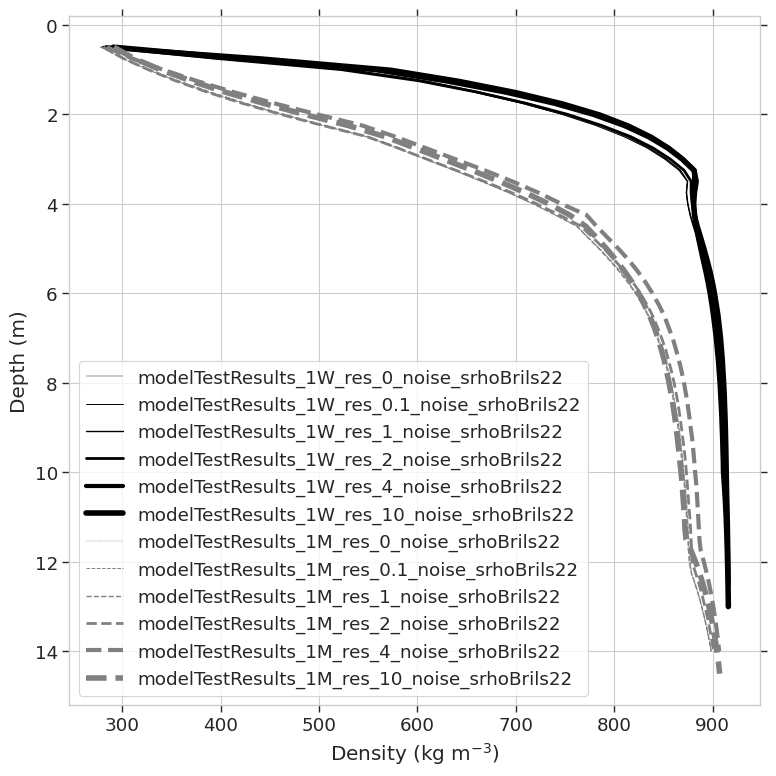

In [88]:
lineStyDict = {'W': 'solid','M': 'dashed'}

listNoise = ['_0_','_0.1_','_1_','_2_','_4_','_10_']
lineThickDict = dict(zip(listNoise,[0.3,0.7,1,2,3,4]))

# make dictionary of plot line types that transitions smoothly between things, and differentiates between W and M  

f1,a1=plt.subplots(figsize=(8,8))
for fn in fns:
    # set line style by resolution
    for n in listNoise:
        if n in fn:
            lw = lineThickDict[n]

    if 'W' in fn:
        ls = lineStyDict['W']
        cl = 'black'
        time = dfCFMrunsW.index.get_level_values(1).unique()
        depth = dfCFMrunsW.index.get_level_values(2).unique()[1:]
        df_mi = dfCFMrunsW
    
    elif 'M' in fn: 
        ls = lineStyDict['M']
        cl = 'grey'
        time = dfCFMrunsM.index.get_level_values(1).unique()
        depth = dfCFMrunsM.index.get_level_values(2).unique()[1:]
        df_mi = dfCFMrunsM

    a1.plot(df_mi.loc[(fn,time[-1],depth),'density'],depth,label=fn, linestyle = ls, linewidth = lw,color = cl)
    # set line width by the noise 
        
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')
fm.saveas(f1,'../figures/' + fn+'_dens')

In [89]:
x = dfCFMrunsW.reindex(indexNames)
x.drop(columns = 'density',inplace = True)
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, modelrun to depth
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  0 non-null      float64
dtypes: float64(1)
memory usage: 48.0+ bytes


In [90]:
dfCFMrunsW.head()

temperature  \
modelrun                                    time        depth                
modelTestResults_1W_res_0_noise_srhoBrils22 1989.002686 0.25   1989.002686   
                                                        0.50    243.344131   
                                                        0.75    243.282257   
                                                        1.00    243.251099   
                                                        1.25    243.233322   

                                                                   density  
modelrun                                    time        depth               
modelTestResults_1W_res_0_noise_srhoBrils22 1989.002686 0.25   1989.002686  
                                                        0.50    278.297180  
                                                        0.75    416.475616  
                                                        1.00    539.002930  
                                                        1.25    607.890198

In [91]:
modelruns_allW = []
modelruns_allM = []
for fn in fns:
    if 'W' in fn:
        modelruns_allW.append(fn)
    elif 'M' in fn:
        modelruns_allM.append(fn)


In [ ]:
# contour plots weekly of the different model runs

levelsT = np.arange(220,280,10)
levelsRho = np.arange(200,600,50)
modelruns_all = dfCFMrunsW.index.get_level_values(0)
modelruns = modelruns_all.unique()
time_all = dfCFMrunsW.index.get_level_values(1)
time = time_all.unique() 
depth_all = dfCFMrunsW.index.get_level_values(2)
depth = depth_all.unique()

for fn in modelruns_allW:

    df_mi = dfCFMrunsW.loc[(modelruns_all==fn,time_all,depth_all),'temperature'].unstack(level = 2)
    df_mi.drop(columns = [0.25],inplace = True)
    df_mi.index = df_mi.index.droplevel(0)
    df_mi = df_mi.transpose()
    
    f1,a1=plt.subplots()
    cp1 = a1.contourf(time,-depth[1:],df_mi.values, len(levelsT), cmap = cm.Blues)
    line_colors = ['black' for l in cp1.levels]
    cp = a1.contour(time,-depth[1:],df_mi.values, levels=levelsT, colors=line_colors)
    a1.clabel(cp,fontsize = 10,inline = 1)
    a1.set_xlabel('time (year)')
    a1.set_ylabel('depth (m)')
    a1.set_xlim(2000,2010)
    a1.set_ylim(-10,0)
    plt.title('temperature: ' + fn)
    cbar = f1.colorbar(cp1, ticks = levelsT)
    cbar.ax.set_yticklabels(levelsT)


    df_mi = dfCFMrunsW.loc[(modelruns_all==fn,time_all,depth_all),'density'].unstack(level = 2)
    df_mi.drop(columns = [0.25],inplace = True)
    df_mi.index = df_mi.index.droplevel(0)
    df_mi = df_mi.transpose()
    
    f2,a2=plt.subplots()
    cp2 = a2.contourf(time,-depth[1:],df_mi.values,levelsRho, cmap = cm.Greys)
    line_colors = ['black' for l in cp1.levels]
    cp = a2.contour(time,-depth[1:],df_mi.values, levels=levelsRho, colors=line_colors)
    a2.clabel(cp,fontsize = 10,inline = 1,fmt='%.0f')
    a2.set_xlabel('time (year)')
    a2.set_ylabel('depth (m)')
    a2.set_xlim(2000,2010)
    a2.set_ylim(-10,0)
    cbar = f2.colorbar(cp2)
    plt.title('density: ' + fn)

    fm.saveas(f1, '../figures/' + fn+'_T')
    fm.saveas(f2, '../figures/' + fn+'_dens')


In [ ]:
# monthly data

levelsT = np.arange(220,280,10)
levelsRho = np.arange(200,600,50)
modelruns_all = dfCFMrunsM.index.get_level_values(0)
modelruns = modelruns_all.unique()
time_all = dfCFMrunsM.index.get_level_values(1)
time = time_all.unique() 
depth_all = dfCFMrunsM.index.get_level_values(2)
depth = depth_all.unique()

for fn in modelruns_allM:

    df_mi = dfCFMrunsM.loc[(modelruns_all==fn,time_all,depth_all),'temperature'].unstack(level = 2)
    df_mi.drop(columns = [0.25],inplace = True)
    df_mi.index = df_mi.index.droplevel(0)
    df_mi = df_mi.transpose()
    
    f1,a1=plt.subplots()
    cp1 = a1.contourf(time,-depth[1:],df_mi.values, levelsT, cmap = cm.Blues)
    line_colors = ['black' for l in cp1.levels]
    cp = a1.contour(time,-depth[1:],df_mi.values, levels=levelsT, colors=line_colors)
    a1.clabel(cp,fontsize = 10,inline = 1)
    a1.set_xlabel('time (year)')
    a1.set_ylabel('depth (m)')
    a1.set_xlim(2000,2010)
    a1.set_ylim(-10,0)
    plt.title('temperature: ' + fn)
    cbar = f1.colorbar(cp1)
    
    df_mi = dfCFMrunsM.loc[(modelruns_all==fn,time_all,depth_all),'density'].unstack(level = 2)
    df_mi.drop(columns = [0.25],inplace = True)
    df_mi.index = df_mi.index.droplevel(0)
    df_mi = df_mi.transpose()
    
    f2,a2=plt.subplots()
    cp2 = a2.contourf(time,-depth[1:],df_mi.values,levelsRho, cmap = cm.Greys)
    line_colors = ['black' for l in cp1.levels]
    cp = a2.contour(time,-depth[1:],df_mi.values, levels=levelsRho, colors=line_colors)
    a2.clabel(cp,fontsize = 10,inline = 1,fmt='%.0f')
    a2.set_xlabel('time (year)')
    a2.set_ylabel('depth (m)')
    a2.set_xlim(2000,2010)
    a2.set_ylim(-10,0)
    cbar = f2.colorbar(cp2)
    plt.title('density: ' + fn)
    fm.saveas(f1, '../figures/'+fn+'_T')
    fm.saveas(f2, '../figures/'+fn+'_dens')
